# Assignmnet 2 (100 points)

### SMS Spam Detection *(100 points)*

<p>You are hired as an AI expert in the development department of a telecommunications company. The first thing on your orientation plan is a small project that your boss has assigned you for the following given situation. Your supervisor has given away his private cell phone number on too many websites and is now complaining about daily spam SMS. Therefore, it is your job to write a spam detector in Python. </p>

<p>In doing so, you need to use a Naive Bayes classifier that can handle both bag-of-words (BoW) and tf-idf features as input. For the evaluation of your spam detector, an SMS collection is available as a dataset - this has yet to be suitably split into train and test data. To keep the costs as low as possible and to avoid problems with copyrights, your boss insists on a new development with Python.</p>

<p>Include a short description of the data preprocessing steps, method, experiment design, hyper-parameters, and evaluation metric. Also, document your findings, drawbacks, and potential improvements.</p>

<p>Note: You need to implement the bag-of-words (BoW) and tf-idf feature extractor from scratch. You can use existing python libraries for other tasks.</p>

**Dataset and Resources**

* SMS Spam Collection Dataset: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

In [1]:
import string
import ssl
from math import log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#### Data Preprocessing

First loading the SMS collection dataset, then start with preprocessing.
+ removing punctuation
+ converting text to lowercase
+ tokenising the text into words
+ removing stopping words, symbols
+ stemming or lemmatising the words

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# the dataset
sms_data = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=['label', 'text'])

# preprocessing
def preprocess_text(text):
    # punctuation (check)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # lowercase (check)
    text = text.lower()
    # tokenize (check)
    tokens = word_tokenize(text)
    # stopwords and non-alphanumeric tokens (check)
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # lemmatisation (check)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # stemming (check)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

# initialising stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# preprocessing application
sms_data['processed_text'] = sms_data['text'].apply(preprocess_text)
print(sms_data.head())

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  label                                               text  \
0   ham  Go until jurong point, crazy.. Available only ...   
1   ham                      Ok lar... Joking wif u oni...   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3   ham  U dun say so early hor... U c already then say...   
4   ham  Nah I don't think he goes to usf, he lives aro...   

                                      processed_text  
0  [go, jurong, point, crazi, avail, bugi, n, gre...  
1                       [ok, lar, joke, wif, u, oni]  
2  [free, entri, 2, wkli, comp, win, fa, cup, fin...  
3      [u, dun, say, earli, hor, u, c, alreadi, say]  
4  [nah, dont, think, go, usf, life, around, though]  


#### Feature Extraction:
1. implementing BoW feature extraction:
- creating a vocabulary from the training data.
- representing each sms as a vector of word counts.

I am adding the function part in comments since putting it as a class makes it more usable in this case, and also in the TF-IDF case. I think, that's what I found online.

In [3]:
class BoWVectorizer:
    def __init__(self):
        self.vocabulary = []

    def fit(self, corpus):
        unique_words = set(word for sms in corpus for word in sms.split())
        self.vocabulary = sorted(unique_words)
        return self

    def transform(self, corpus):
        vocab_index = {word: idx for idx, word in enumerate(self.vocabulary)}
        vectors = []
        
        for sms in corpus:
            vector = np.zeros(len(self.vocabulary), dtype=int)
            for word in sms.split():
                if word in vocab_index:
                    vector[vocab_index[word]] += 1
            vectors.append(vector)
        
        return np.array(vectors)

    def fit_transform(self, corpus):
        self.fit(corpus)
        return self.transform(corpus)
    
# def bag_of_words(documents):
#     vocab = {}
#     for doc in documents:
#         for word in doc.split():
#             if word not in vocab:
#                 vocab[word] = len(vocab)
    
#     bow_matrix = []
#     for doc in documents:
#         row = [0] * len(vocab)
#         for word in doc.split():
#             if word in vocab:
#                 row[vocab[word]] += 1
#         bow_matrix.append(row)
#     return bow_matrix, vocab

2. implementing tf-idf feature extraction:
   - calculating term frequency (TF) for each word in each sms
   - also the inverse document frequency (IDF) for each word
   - then computing tf-idf scores for each word in each sms

In [4]:
class TfidfVectorizer:
    def __init__(self, smooth=1):
        self.vocabulary = []
        self.idf = {}
        self.smooth = smooth

    def fit(self, corpus):
        doc_count = len(corpus)
        unique_words = set(word for sms in corpus for word in sms.split())
        self.vocabulary = sorted(unique_words)
        
        # Calculate IDF
        self.idf = {
            word: log((doc_count + self.smooth) / (sum(1 for sms in corpus if word in sms.split()) + self.smooth)) 
            for word in self.vocabulary
        }
        print(f"Vocabulary and IDF values calculated.")
        return self

    def transform(self, corpus):
        vectors = []
        vocab_index = {word: idx for idx, word in enumerate(self.vocabulary)}

        for sms in corpus:
            vector = np.zeros(len(self.vocabulary))
            word_counts = {}
            
            for word in sms.split():
                if word in vocab_index:
                    word_counts[word] = word_counts.get(word, 0) + 1

            total_words = sum(word_counts.values())
            
            for word, count in word_counts.items():
                tf = count / total_words
                vector[vocab_index[word]] = tf * self.idf[word]

            vectors.append(vector)

        return np.array(vectors)

    def fit_transform(self, corpus):
        self.fit(corpus)
        return self.transform(corpus)
    

#### Naive Bayes Classifier:
1. implement a naive bayes classifier:
   - training classifier by using the training data
   - using laplace smoothing to handle zero probabilities
   - calculating conditional probabilities for each class (spam or ham) and each word together
   - apply logarithmic probabilities to avoid underflow
2. prediction making on the test data

In [5]:
class NaiveBayesClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.prior = {}
        self.cond_prob = {}

    def fit(self, X_train, y_train):
        unique_classes = np.unique(y_train)
        
        # Calculate prior probabilities (log priors)
        self.prior = {label: np.log((np.sum(y_train == label) + self.alpha) / 
                                    (len(y_train) + len(unique_classes) * self.alpha)) 
                      for label in unique_classes}
        
        # Calculate conditional probabilities
        self.cond_prob = {label: np.zeros(X_train.shape[1]) for label in unique_classes}
        
        for label in unique_classes:
            label_indices = np.where(y_train == label)[0]
            X_label = X_train[label_indices]
            total_words = X_label.sum()
            
            word_counts = np.array(X_label.sum(axis=0)).flatten()  # Word counts across all features
            
            # Log probability smoothing
            self.cond_prob[label] = np.log((word_counts + self.alpha) / 
                                           (total_words + X_train.shape[1] * self.alpha))
        
        return self

    def predict(self, X):
        # Calculate log probabilities for each class
        log_probs = []
        for label in self.prior:
            # Sum the log probabilities
            log_prob = self.prior[label] + X @ self.cond_prob[label].T
            log_probs.append(log_prob)
        
        # Pick the class with the highest probability
        return np.array(list(self.prior.keys()))[np.argmax(log_probs, axis=0)]

# def tf_idf(documents):
#     vocab = {}
#     doc_count = len(documents)
    
#     for doc in documents:
#         for word in doc.split():
#             if word not in vocab:
#                 vocab[word] = len(vocab)
    
#     tf_matrix = []
#     for doc in documents:
#         term_freq = {word: 0 for word in vocab}
#         for word in doc.split():
#             term_freq[word] += 1
#         total_terms = len(doc.split())
#         tf_matrix.append([term_freq[word] / total_terms for word in vocab])
    
#     idf = {word: log((1 + doc_count) / (1 + sum(1 for doc in documents if word in doc.split()))) + 1 
#            for word in vocab}
    
#     tf_idf_matrix = []
#     for tf_row in tf_matrix:
#         tf_idf_row = [tf_val * idf[word] for word, tf_val in zip(vocab, tf_row)]
#         tf_idf_matrix.append(tf_idf_row)
    
#     return tf_idf_matrix, vocab

#### Experiment Design:
1. spliting the dataset into training and testing sets
2. training the naive bayes classifier on the training set
3. evaluating the classifier on the testing set using appropriate evaluation metrics -> accuracy, precision, recall, F1-score

In [ ]:
X = sms_data['text']
y = sms_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
X_train_transformed = vectorizer.transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

classifier = MultinomialNB()
classifier.fit(X_train_transformed, y_train)
predictions = classifier.predict(X_test_transformed)
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, pos_label='spam')
recall = recall_score(y_test, predictions, pos_label='spam')
f1 = f1_score(y_test, predictions, pos_label='spam')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Vocabulary and IDF values calculated.
Accuracy: 0.9650224215246637
Precision: 0.9824561403508771
Recall: 0.7516778523489933
F1-score: 0.8517110266159695


### Hyperparameters:
- laplace smoothing parameter - alpha - for naive bayes.

In [7]:
# alpha values (laplace smoothing)
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# naive bayes classifier
classifier = MultinomialNB()

# grid search - 5 fold cross validation
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)

# the best alpha - the corresponding classifier
best_alpha = grid_search.best_params_['alpha']
best_classifier = grid_search.best_estimator_

# the best classifier
best_classifier.fit(X_train_transformed, y_train)

# prediction
predictions = best_classifier.predict(X_test_transformed)

# evaluation
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, pos_label='spam')
recall = recall_score(y_test, predictions, pos_label='spam')
f1 = f1_score(y_test, predictions, pos_label='spam')

print("Best Alpha:", best_alpha)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Best Alpha: 0.5
Accuracy: 0.9748878923766816
Precision: 0.9763779527559056
Recall: 0.8322147651006712
F1-score: 0.8985507246376812


### Evaluation Metric:
- checking the differenece between BoW and tf-idf
- accuracy: the proportion of correctly classified sms messages
- precision: the proportion of correctly classified spam messages between all messages classified as spam
- recall: the proportion of correctly classified spam messages from all actual spam messages
- f1-score: the harmonic mean of precision and recall, providing a balance between the two metrics

Vocabulary and IDF values calculated.
  Vectorizer  Accuracy  Precision (Spam)  Recall (Spam)  F1-Score (Spam)
0        BoW  0.984753          0.992537       0.892617         0.939929
1     TF-IDF  0.965022          0.982456       0.751678         0.851711


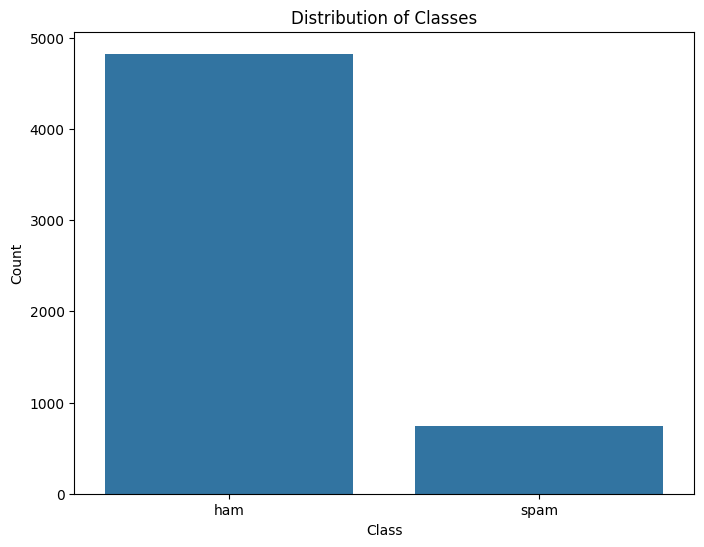

In [8]:
def evaluate_model(model, X_train, X_test, y_train, y_test, vectorizer_name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, pos_label='spam')
    recall = recall_score(y_test, predictions, pos_label='spam')
    f1 = f1_score(y_test, predictions, pos_label='spam')
    
    return {
        'Vectorizer': vectorizer_name,
        'Accuracy': accuracy,
        'Precision (Spam)': precision,
        'Recall (Spam)': recall,
        'F1-Score (Spam)': f1
    }

metrics_list = []

bow_vectorizer = BoWVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

metrics_list.append(evaluate_model(MultinomialNB(), X_train_bow, X_test_bow, y_train, y_test, "BoW"))

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

metrics_list.append(evaluate_model(MultinomialNB(), X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF"))

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df)

# class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=sms_data)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# An Optimised Version from ChatGPT
it is a lot different from what i got :/

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Best Parameters: {'classifier__alpha': 0.1}
Accuracy: 0.9821
Precision: 0.9448
Recall: 0.9195
F1-score: 0.9320


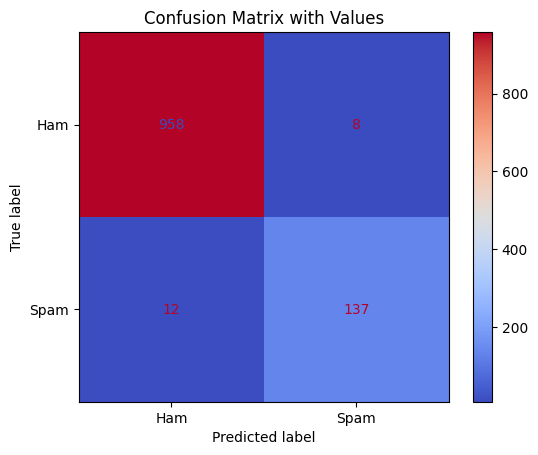

In [9]:
# Importing necessary libraries
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import numpy as np

# Downloading NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Loading the dataset
sms_data = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=['label', 'text'])

# Custom Preprocessor Class
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def preprocess(self, text):
        text = text.translate(str.maketrans('', '', string.punctuation)).lower()
        tokens = word_tokenize(text)
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in self.stop_words]
        return ' '.join([self.stemmer.stem(word) for word in tokens])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.preprocess)

# Custom BoW Vectorizer (from scratch)
class BoWVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vocabulary = {}

    def fit(self, X, y=None):
        unique_words = set(word for sms in X for word in sms.split())
        self.vocabulary = {word: i for i, word in enumerate(sorted(unique_words))}
        return self

    def transform(self, X):
        vectors = []
        for sms in X:
            vector = np.zeros(len(self.vocabulary))
            for word in sms.split():
                if word in self.vocabulary:
                    vector[self.vocabulary[word]] += 1
            vectors.append(vector)
        return np.array(vectors)

# Custom TF-IDF Vectorizer (from scratch)
class TfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, smooth=1):
        self.smooth = smooth
        self.vocabulary = {}
        self.idf_values = {}

    def fit(self, X, y=None):
        doc_count = len(X)
        unique_words = set(word for sms in X for word in sms.split())
        self.vocabulary = {word: i for i, word in enumerate(sorted(unique_words))}
        self.idf_values = {
            word: np.log((doc_count + self.smooth) / (1 + sum(1 for sms in X if word in sms.split())))
            for word in self.vocabulary
        }
        return self

    def transform(self, X):
        vectors = []
        for sms in X:
            vector = np.zeros(len(self.vocabulary))
            word_counts = {}
            for word in sms.split():
                if word in self.vocabulary:
                    word_counts[word] = word_counts.get(word, 0) + 1
            total_words = sum(word_counts.values())
            for word, count in word_counts.items():
                tf = count / total_words
                vector[self.vocabulary[word]] = tf * self.idf_values[word]
            vectors.append(vector)
        return np.array(vectors)

# Splitting data
X = sms_data['text']
y = sms_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline for preprocessing, vectorization, and classification
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', TfidfVectorizer()),  # Change to BoWVectorizer() for BoW
    ('classifier', MultinomialNB())
])

# Hyperparameter Tuning
param_grid = {'classifier__alpha': [0.1, 0.5, 1.0, 2.0]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Evaluation
best_pipeline = grid_search.best_estimator_
predictions = best_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, pos_label='spam')
recall = recall_score(y_test, predictions, pos_label='spam')
f1 = f1_score(y_test, predictions, pos_label='spam')

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot the confusion matrix with numerical values
conf_matrix = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Ham', 'Spam'])

# Plot with color intensity and values
disp.plot(cmap='coolwarm', values_format='d')
plt.title('Confusion Matrix with Values')
plt.show()

### Additional Experiments *(5 additional points - <span style="color: red;">Optional</span>)*

#### BoW with Bigrams

In [10]:
bow_vectorizer = CountVectorizer(ngram_range=(1, 2)) 
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

classifier.fit(X_train_bow, y_train)
predictions_bow = classifier.predict(X_test_bow)

accuracy_bow = accuracy_score(y_test, predictions_bow)
f1_bow = f1_score(y_test, predictions_bow, pos_label='spam')

print(f"BoW (with bigrams) Accuracy: {accuracy_bow}")
print(f"BoW (with bigrams) F1-Score: {f1_bow}")

BoW (with bigrams) Accuracy: 0.989237668161435
BoW (with bigrams) F1-Score: 0.958041958041958


#### Finding Top 500 Features

In [11]:
bow_vectorizer = CountVectorizer(max_features=500)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

classifier.fit(X_train_bow, y_train)
predictions_bow = classifier.predict(X_test_bow)

accuracy_bow = accuracy_score(y_test, predictions_bow)
f1_bow = f1_score(y_test, predictions_bow, pos_label='spam')

print(f"BoW (Top 500 Features) Accuracy: {accuracy_bow}")
print(f"BoW (Top 500 Features) F1-Score: {f1_bow}")

BoW (Top 500 Features) Accuracy: 0.979372197309417
BoW (Top 500 Features) F1-Score: 0.9235880398671097


#### Top Indicative Words for Spam

In [12]:
feature_names = bow_vectorizer.get_feature_names_out()
spam_feature_log_probs = classifier.feature_log_prob_[1] 
top_features = np.argsort(spam_feature_log_probs)[-10:] 

print("Top indicative words for spam:")
for i in top_features:
    print(f"{feature_names[i]}: {np.exp(spam_feature_log_probs[i]):.4f}") 

Top indicative words for spam:
txt: 0.0136
or: 0.0175
the: 0.0175
for: 0.0178
now: 0.0182
free: 0.0206
your: 0.0233
you: 0.0250
call: 0.0308
to: 0.0604
